In [1]:
# cargamos las librerias a utilizar

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


In [2]:
# esta celda sirve para dar permiso al accedo de tus archivos del gdrive
link ='https://docs.google.com/spreadsheets/d/e/2PACX-1vTRmmsm3qKHPv04W2q5Vp57bVLa6tc706boLNhS7mVtH1hh4gpkAfRT7d1XsQYd1g/pub?gid=145097224&single=true&output=csv'

In [3]:
df = pd.read_csv(link)
df.head()

,timestamp,demand
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [4]:
# colocar el campo fecha como indice

df = df.set_index('timestamp')
df.head()

,demand
timestamp,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [5]:
# seleccionamos las variables de interés

dataset = df.values

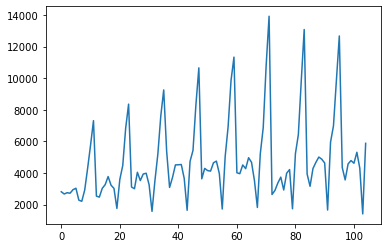

In [6]:
# redimensionando la variable en vector columna reshape (-1,1)
# luego se plotea

dataset = dataset.reshape(-1,1)
plt.plot(dataset)

MIN_MAX_Scaler

In [7]:
# escalando datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range = (0,1))
dataset = scaler.fit_transform(dataset)

Creando los conjuntos de entrenamiento y testing

In [8]:
# train_test_split

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Crear la función que transforma el vector de la serie en una matriz

In [9]:
# función que convierte a array

def to_sequences(dataset, seq_size = 1):
    x=[]
    y=[]
    
    for i in range(len(dataset) - seq_size-1):
        window = dataset[i:(i+seq_size),0]
        x.append(window)
        y.append(dataset[i+seq_size,0])
    
    return np.array(x),np.array(y)

Utilizamos la función en la data train - test

In [10]:
# seq_size es el número de columnas que tendrá la matriz : timesteps

seq_size = 12

trainX, trainY = to_sequences(train,seq_size)
testX, testY = to_sequences(test,seq_size)

In [11]:
# verificamos las dimensiones de tabla plana

print(trainX.shape)
print(testX.shape)

(71, 12)
(8, 12)


Convertimos las tablas planas a tensores 3D

In [12]:
# redimensionando los inputs para la CNN

# reshape from [samples, timesteps] into [samples, timesteps, features]
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

print(trainX.shape, testX.shape)

(71, 12, 1) (8, 12, 1)


In [13]:
# Creando la red neuronal
# input_shape (columnas, características)

model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape = (seq_size, 1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Entrenando la red CNN

In [14]:
EPOCHS = 100

history = model.fit(trainX,trainY,epochs=EPOCHS,validation_data=(testX,testY), verbose = 1)

Epoch 1/100
3/3 [==============================] - 0s 37ms/step - loss: 0.0730 - val_loss: 0.0102
Epoch 2/100
3/3 [==============================] - 0s 3ms/step - loss: 0.0421 - val_loss: 0.0307
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0393 - val_loss: 0.0347
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0344 - val_loss: 0.0198
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0269 - val_loss: 0.0085
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0227 - val_loss: 0.0050
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0045
Epoch 8/100
3/3 [==============================] - 0s 7ms/step - loss: 0.0166 - val_loss: 0.0046
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0055
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 0.0049
Epoch 11/100
3/3 [==========

Text(0.5, 1.0, 'ECM vs. epochs')

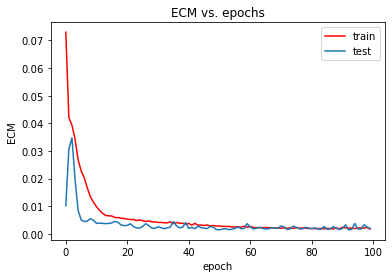

In [15]:
# ECM error cuadrático medio

plt.plot(history.history['loss'],color = 'r', label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('epoch')
plt.ylabel('ECM')
plt.legend(loc = 'best')
plt.title('ECM vs. epochs')

In [16]:
# predicciones

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [17]:
# preparando data para el plot

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size,:] = trainPredict

# shift test predictions 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1:] = testPredict

Plot entrenamiento, predicciones test , vs data real

<function matplotlib.pyplot.show(close=None, block=None)>

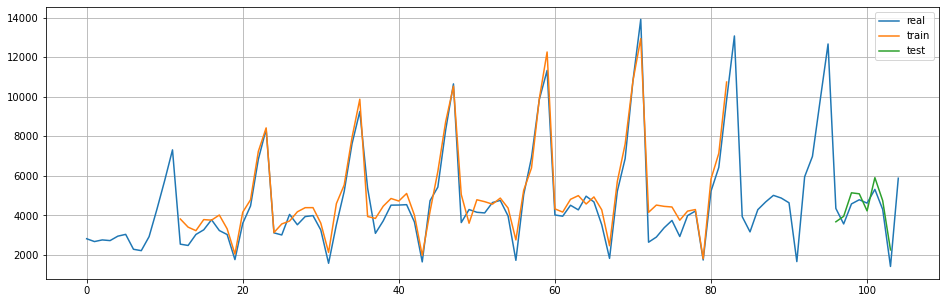

In [18]:
plt.figure(figsize=(16,5))

plt.plot(scaler.inverse_transform(dataset), label ='real')
plt.plot(trainPredictPlot, label = 'train')
plt.plot(testPredictPlot, label = 'test')
plt.legend(loc = 'best')
plt.grid()
plt.show

Pronóstico

In [19]:
# data de test

testX.shape

(8, 12, 1)

In [20]:
# el último registro de la data de test

testX, testY = to_sequences(test,seq_size)
testX = testX[-1,:].reshape(-1,12)
testX.shape

(1, 12)

In [21]:
# convierto a 3D

x_test = testX.reshape((testX.shape[0], testX.shape[1],1))
x_test.shape

(1, 12, 1)

In [22]:
# con esto lleno la matriz para seguir calculando los días 2 de diciembre en adelante con los 12 previos
# puedes mover el parametro para hacer pronóstico de más o menos puntos

parametro = 24

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[1]-1):
        x_test[0][i][0] = x_test[0][i+1][0]
    x_test[0][x_test.shape[1]-1][0] = nuevoValor
    return x_test

results = []
for i in range(parametro):
    parcial = model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test = agregarNuevoValor(x_test,parcial[0])

[[[0.01967528]
  [0.3629529 ]
  [0.4453331 ]
  [0.67487806]
  [0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]]]
[[[0.3629529 ]
  [0.4453331 ]
  [0.67487806]
  [0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]
  [0.06690101]]]
[[[0.4453331 ]
  [0.67487806]
  [0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]
  [0.06690101]
  [0.38454705]]]
[[[0.67487806]
  [0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]
  [0.06690101]
  [0.38454705]
  [0.4843678 ]]]
[[[0.90034395]
  [0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]
  [0.23074463]
  [0.06690101]
  [0.38454705]
  [0.4843678 ]
  [0.77797663]]]
[[[0.23474365]
  [0.1720387 ]
  [0.25305927]
  [0.26993522]
  [0.25633848]
  [0.31184515]


In [23]:
# valores inversos al escalado

adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[ 2249.46333229],
       [ 6220.99181931],
       [ 7469.05045432],
       [11140.04186208],
       [14084.89159514],
       [ 4414.95477034],
       [ 4455.00398654],
       [ 5353.30506843],
       [ 4672.47826741],
       [ 4491.0289236 ],
       [ 5514.71219792],
       [ 4737.43236857],
       [ 2616.33981492],
       [ 6717.16829781],
       [ 8189.6952618 ],
       [11939.91801885],
       [15309.47079703],
       [ 4687.75785915],
       [ 5288.62968586],
       [ 5894.05490991],
       [ 4617.57256771],
       [ 4606.15404825],
       [ 5593.90181395],
       [ 5011.00957218]])

In [24]:
# concatenar df

df.head()

,demand
timestamp,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [25]:
y_pred=pd.DataFrame(inverted)
len(y_pred)

24

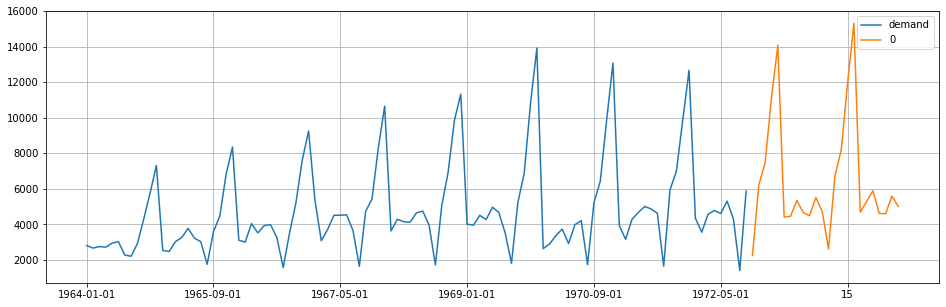

In [26]:
df2=pd.concat([df,y_pred])
df2.plot(figsize=(16,5))
plt.grid()